In [2]:
#%%
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Jan 3 2021

@author: aidanrogers
"""

import mne

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib qt
import os, sys
#import keyboard
import time
import pathlib
from autoreject import AutoReject
import os
from os.path import join
from os import chdir


#mne.viz.set_3d_options(antialias=False, depth_peeling = False, smooth_shading = False)
#mne.viz.set_3d_backend('pyvista')

if os.name == 'posix': # linux
    D_Drive = '/mnt/d/Aidan'
    root_dir = '~'
    SUBJECTS_DIR = os.getenv('SUBJECTS_DIR')
    FREESURFER_HOME = os.getenv('FREESURFER_HOME')
elif os.name == 'nt': # windows
    D_Drive = 'D:\Aidan'
    root_dir = join("C:\\","Users","aar40","AppData","Local","Packages",
                           "CanonicalGroupLimited.Ubuntu22.04LTS_79rhkp1fndgsc","LocalState","rootfs")
    FREESURFER_HOME = join(root_dir, "usr", "local", "freesurfer", "7.3.2")
    SUBJECTS_DIR = join(FREESURFER_HOME,'subjects')
    os.environ['SUBJECTS_DIR'] = SUBJECTS_DIR
    os.environ['FREESURFER_HOME'] = FREESURFER_HOME
else:
    raise SystemError('Unknown system os')

mne.viz.set_3d_options(antialias=False)
mne.viz.set_3d_backend('pyvista')

#cd D:\Aidan
%matplotlib qt

#D:/Aidan/E1/BrainVision_Recorder/E1_TwoBeeps.vhdr
#124_Ch_Test.bvef

def sleeper():
    """
    Attempted function to streamline code
    
    function was used to try and cause pauses between opening plots 
    for EEG analysis

    """
    while True:
        num = 300
        
        try:
            num = float(num)
        except ValueError:
            print('Please enter in a number.\n')
            continue
        print('before: %s' % time.ctime())
        time.sleep(num)
        print('After: %s\n' % time.ctime())
    

def make_montage():
    """
    creates montage, identifies and finds the montage, then makes sure data 
    is properly aligned with electrode placement we want 

    Parameters
    ----------
    montage_fname : montage
        DESCRIPTION - electrode placement on head of specific subj (128)
    subj_num : TYPE
        DESCRIPTION - the subject # - who's file are we accessing?

    Returns
    -------
    montage : montage
        DESCRIPTION  - aligned montage
    raw : raw
        DESCRIPTION - bandpass filtered raw data file

    """
    # have to be in same directory as the file ur looking at to access b/c MNE
    os.chdir(D_Drive)
    
    
    montage_fname = input ('Are you using a custom (C) or default (D) montage/electrode placement ')
    subj_num = input('what subject # are you analyzing: ')
    
    
    # to be used for the inverse solution (making the bem, coregistraton, covariance etc)
    global subj 
    subj = 'E'+ subj_num
    global subject
    subject = subj
    
    # to be used for the inverse solution (making the bem, coregistraton, covariance etc)
    # global subjects_dir
    # global FREESURFER_HOME
    # subjects_dir = 'C:/Users/aar40/Desktop/share/freesurfer/subjects'
    # FREESURFER_HOME = 'C:/Users/aar40/Desktop/share/freesurfer'

    # mne.set_config(key = subjects_dir, value = 'E46')
    
    # to identify the correct montage/electrode config
    if (montage_fname == 'D'):
        montage_name = '124_Ch_Test.bvef'
        #load default montage / electrode position
        montage = mne.channels.read_custom_montage(montage_name)
    elif (montage_fname == 'C'):
        #load custom montage / electrode position
        montage_name = traverse('CapTrak', subj, subj, '.bvct')
        montage = mne.channels.read_dig_captrak(montage_name)
    else:
        print('invalid input')

    
    
    
    vhdr1 = 'TwoBeeps' #change these to change what type of file you're analyzinbg
    vhdr2 = '.vhdr'
    vhdr_fname = traverse(os.sep + 'BrainVision_Recorder', subj, vhdr1, vhdr2)
   # vhdr_fname = ''

    #vhdr_path = 'D:\Aidan/' + subj + '/BrainVision_Recorder/'     
    #vhdr_fname = (filenames for _,_,filenames in os.walk(vhdr_path) if vhdr1 & vhdr2 in filenames)
    raw = mne.io.read_raw_brainvision(vhdr_fname, preload=True)
    
    #Channel renaming dictionary for TwoBeeps subjs E2 - 27
    if ((int(subj_num) > 1) & (int(subj_num) < 28 )):
        raw = load_data_skewed(raw);
    
    if (subj != 'E1'): #set eog
        raw.set_channel_types({'125':'eog','126':'eog','127':'eog','128':'eog'})
        
    #apply bandpass filter, set frequency bands
    raw.filter(0.5,40)
    
    #after filtering, remove bad channels in qt plot
    raw.plot()
    # print("wait")
    # wait = input('Press a key to continue: ')
    # print("continue")
    #cont = keyboard.read_key()
    #raw.set_eeg_reference('average')
    # raw.set_eeg_reference('average', projection=True)

    # raw.set_montage(montage)
    # raw.save(pathlib.Path('/mnt/d/Aidan/' + subj + '/Digitization') / 'Captrak_Digitization.fif', overwrite = True)
    
    return montage, raw

def traverse(where, subj, vhdr1, vhdr2):
    global vhdr_fname_1
    # for dirpath, dirnames, filenames in os.walk('D:\Aidan/' + subj + where):
    for dirpath, dirnames, filenames in os.walk(D_Drive + os.sep + subj + os.sep + where):
        for name in filenames:
            if vhdr1 in name:
                if vhdr2 in name:
                    vhdr_fname_1 = dirpath + os.sep + name 
                    print(vhdr_fname_1)
                    print(type(vhdr_fname_1))
                    return vhdr_fname_1

def load_data_skewed(raw):
    '''
    takes in raw data file and makes sure the channels (which were missnamed)
    are re-aligned given a dictionary

    Parameters
    ----------
    raw : raw
        DESCRIPTION - raw data file

    Returns
    -------
    raw : raw
        DESCRIPTION - data aligned with correct electrode orientation

    '''
    #Load in EEG file
    # raw = mne.io.read_raw_brainvision(vhdr_fname, preload=True)

    #Channel renaming dictionary for TwoBeeps subjs E2 - 27
    #1-32:97:128, 33-64:65-96, 65-96:33-64. 97-128:1-32
    name_dict = {'1':'97','2':'98','3':'99','4':'100','5':'101','6':'102',
             '7':'103','8':'104','9':'105','10':'106','11':'107','12':'108',
             '13':'109','14':'110','15':'111','16':'112','17':'113',
             '18':'114','19':'115','20':'116','21':'117','22':'118',
             '23':'119','24':'120','25':'121','26':'122','27':'123',
             '28':'124','29':'125','30':'126','31':'127','32':'128','33':'65',
             '34':'66','35':'67','36':'68','37':'69','38':'70','39':'71',
             '40':'72','41':'73','42':'74','43':'75','44':'76','45':'77',
             '46':'78','47':'79','48':'80','49':'81','50':'82','51':'83',
             '52':'84','53':'85','54':'86','55':'87','56':'88','57':'89',
             '58':'90','59':'91','60':'92','61':'93','62':'94','63':'95',
             '64':'96','65':'33','66':'34','67':'35','68':'36','69':'37',
             '70':'38','71':'39','72':'40','73':'41','74':'42','75':'43',
             '76':'44','77':'45','78':'46','79':'47','80':'48','81':'49',
             '82':'50','83':'51','84':'52','85':'53','86':'54','87':'55',
             '88':'56','89':'57','90':'58','91':'59','92':'60','93':'61',
             '94':'62','95':'63','96':'64','97':'1','98':'2','99':'3',
             '100':'4','101':'5','102':'6','103':'7','104':'8','105':'9',
             '106':'10','107':'11','108':'12','109':'13','110':'14',
             '111':'15','112':'16','113':'17','114':'18','115':'19',
             '116':'20','117':'21','118':'22','119':'23','120':'24',
             '121':'25','122':'26','123':'27','124':'28','125':'29',
             '126':'30','127':'31','128':'32'}
    
    #list to reorder channels after renaming
    order_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13',
                  '14','15','16','17','18','19','20','21','22','23','24','25',
                  '26','27','28','29','30','31','32','33','34','35','36','37',
                  '38','39','40','41','42','43','44','45','46','47','48','49',
                  '50','51','52','53','54','55','56','57','58','59','60','61',
                  '62','63','64','65','66','67','68','69','70','71','72','73',
                  '74','75','76','77','78','79','80','81','82','83','84','85',
                  '86','87','88','89','90','91','92','93','94','95','96','97',
                  '98','99','100','101','102','103','104','105','106','107',
                  '108','109','110','111','112','113','114','115','116','117',
                  '118','119','120','121','122','123','124','125','126','127',
                  '128']

    #rename channels based on above dictionary
    raw.rename_channels(name_dict)
    
    #reorder channels to go sequentially from 1 to 128
    raw.reorder_channels(order_list)
    
    return raw
    
    
def set_data(raw, montage):
    '''
    common average reference.
    take the average signal across all electrodes and take it off the top
    reduces noise by 30% - on average
    '''
    #set reference to average    
    raw.set_eeg_reference('average', projection=True)
    
    #plot data again to remove any remaining bad channels
    raw.plot()
    
    #cont = keyboard.read_key()


    return raw
    

def EOG_check(raw2, ica):
    '''
    1. regenerates epochs, and evoked (avg epochs)
    2. uses find_bads_eog locations and saves those voltages and time periods
    3. plot functions (some are commented out)
    4. ica.exclude.extend(eog_indices) --> 
    --> plots newly excluded indices as a copy of raw data
    5. display new ERP (doesn't save the data to the main raw file)
    '''
    eog_epochs=mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.1))
    # eog_epochs.plot_image(combine='mean')
    # eog_epochs.average().plot_joint()
    eog_average = eog_epochs.average()

    # ica.exclude = []
    # find which ICs match the EOG pattern
    # eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
    [eog_indices,eog_scores]=ica.find_bads_eog(eog_epochs)
    
    # barplot of ICA component "EOG match" scores
    # ica.plot_scores(eog_scores, exclude=eog_indices)
    
    # plot diagnostics
    #ica.plot_properties(raw2, picks=eog_indices)
    
    # plot ICs applied to raw data, with EOG matches highlighted
    # ica.plot_sources(raw2, show_scrollbars=True)
    
    # plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
    ica.plot_sources(eog_average)
    
    #ica.plot_properties(eog_epochs, picks=eog_indices, psd_args={'fmax': 35.},
    #                image_args={'sigma': 1.})
    #print(ica.labels_)
    
    ica.plot_overlay(eog_average, exclude=eog_indices, show=True, title = 'average_indices removed')
    ica.plot_overlay(inst = raw2, exclude = eog_indices, title = 'raw before and blink detection')

    
    ica.exclude.extend(eog_indices)
    
    reconst_raw = raw2.copy()
    ica.apply(inst=reconst_raw)
    
    erp(reconst_raw, montage)    
    
    return reconst_raw
    

def EOG_check_ar(epochs_ar, ica):
    '''
    1. regenerates epochs, and evoked (avg epochs)
    2. uses find_bads_eog locations and saves those voltages and time periods
    3. plot functions (some are commented out)
    4. ica.exclude.extend(eog_indices) --> 
    --> plots newly excluded indices as a copy of raw data
    5. display new ERP (doesn't save the data to the main raw file)
    '''
    evoked_ar = epochs_ar.average()

    [eog_indices,eog_scores]=ica.find_bads_eog(epochs_ar)

    # plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
    ica.plot_sources(evoked_ar)
    
    ica.exclude.extend(eog_indices)
    
    reconst_raw = epochs_ar.copy()
    ica.apply(inst=reconst_raw)
    
    evoked = reconst_raw.average()
    evoked.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked.plot_topomap(times=times, ch_type='eeg')
    
    return evoked, reconst_raw
        
    
def EOG_annot(raw2, ica):
    '''
    annotates data for when a bad blink occurs
        - occurences (when EOG channels are correlated with specific electrode channel activity)
    
    Current Issues:
        - overwriting stimulus annotations from original data

    '''
    # make a file, that has the file with the components rempved
    #     then plot that clean data
    #     0 is the ocular event
    # you can reconstruct your, 
    # Review removing the ICA components on their own
    #     project components back into the data
    #         then subtract it fromthe data
    #             have aw and then signal, then put them back
    #             put the data back into original format, then you add it all together,
    #             subtract tthe components you don't want
                

    eog_events = mne.preprocessing.find_eog_events(raw2)
    onsets = eog_events[:, 0] / raw.info['sfreq']-0.25 
    #take all the indices, divided by the sample rate, 2500hz,-0.25
    durations = [0.6] * len( eog_events)
    print(len(eog_events))
    descriptions = ['bad blink'] * len( eog_events)
    blink_annot = mne.Annotations(onsets, durations, descriptions,
                                  orig_time=raw.info['meas_date'])
    raw2.set_annotations(blink_annot)
    eeg_picks = mne.pick_types(raw2.info, meg=False, eeg=True)
    raw2.plot(events= eog_events, order=eeg_picks)
    #raw.plot(events= eog_indices, order=eeg_picks)

    return raw2


def erp_blink(raw, montage):
    '''
    takes annotated data, wherever bad blink is listed
    removes the annotation and then plots data

    '''
    #get events and their IDs from annotations in recorded eeg data
    getData = mne.events_from_annotations(raw, event_id={'bad blink':998})


    events = getData[0]
    event_id = getData[1]

    tmin = -0.5
    tmax = 1.0
    baseline = (-0.5, -0.1)
    
    #create epochs with baseline subtraction 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, 
                        tmax=tmax, proj=True, baseline=baseline, preload=True,
                        reject_by_annotation=True)
    
    #create ERP
    evoked = epochs.average()
    evoked.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked.plot_topomap(times=times, ch_type='eeg')
    #cont = keyboard.read_key()
    
    
def erp(raw, montage):  
    '''
    1. gets stimuli events from annotations in OG data set
    2. separate the ID's
    3. generate epochs
    (slices of time from tmin to tmax based around stimuli occurences)
    4. plot the average epoch (evoked)
    5. set evoked plot to match the electrode placements
    6. plot topographic map of the average epoch centered on the stimuli
    
    plots the ERP #5

    '''
    #get events and their IDs from annotations in recorded eeg data
    getData = mne.events_from_annotations(raw, event_id={'Stimulus/S  1':1,
                                                         'Stimulus/S  2':2,})
    #                                                      'Stimulus/S  3':3,
    #                                                      'Stimulus/S  4':4})
    # print(getData[0])
    # print(getData[1])
    events = getData[0]
    event_id = getData[1]

    tmin = -0.5
    tmax = 1.0
    baseline = (-0.5, -0.1)
    
    #create epochs with baseline subtraction 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, 
                        tmax=tmax, proj=True, baseline=baseline, preload=True,
                        reject_by_annotation=False)
    
    #create ERP
    evoked = epochs.average()
    evoked.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked.plot_topomap(times=times, ch_type='eeg')
    
    return epochs
    #cont = keyboard.read_key()
 
    
def ica_func(raw2):
    '''
    does ICA on the EEG data

    '''
    #define ica method, default fastica
    ica = mne.preprocessing.ICA(method="fastica")
    
    #fit data to ica
    ica.fit(raw2)
    

    #plot ica components, set inst=data to make plots interactive
    ica.plot_components(ch_type='eeg', inst=raw2) #, topomap_args={'data':raw})
    
    #cont = keyboard.read_key()
    # reconst_raw = raw2.copy()
    # ica.apply(inst=reconst_raw)
    

    # ica.plot_overlay(inst = reconst_raw)

    return ica

def autorej(epochs):
    
    n_interpolates = np.array([1, 4, 32])
    consensus_percs = np.linspace(0, 1.0, 11)
    ar = AutoReject(n_interpolates, consensus_percs, random_state = 26042021)
    
    ar.fit(epochs)
    
    epochs_ar, reject_log = ar.transform(epochs, return_log = True)
    
    #reject_log.plot_epochs(epochs, scalings = {"eeg":1e-4})
    
    evoked_ar = epochs_ar.average()
    evoked_ar.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked_ar.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked_ar.plot_topomap(times=times, ch_type='eeg')

    return epochs_ar

def ICA_auto_rej(epochs_ar):
    '''
    does ICA on the EEG data

    '''
    #define ica method, default fastica
    ica = mne.preprocessing.ICA(method="fastica")
    
    #fit data to ica
    ica.fit(epochs_ar)
    

    #plot ica components, set inst=data to make plots interactive
    ica.plot_components(ch_type='eeg', inst=epochs_ar) #, topomap_args={'data':raw})
    
    #cont = keyboard.read_key()
    # reconst_raw = raw2.copy()
    # ica.apply(inst=reconst_raw)
    

    # ica.plot_overlay(inst = reconst_raw)

    return ica


## COREGISTRATION STEPS

def BEM(SUBJECTS_DIR):
    surfaces = mne.bem.make_watershed_bem(subj, subjects_dir = SUBJECTS_DIR)
    surfaces = mne.bem.make_scalp_surfaces(subj, subjects_dir = SUBJECTS_DIR)
    mne.viz.plot_bem(subject = subj, subjects_dir = SUBJECTS_DIR, orientation = 'coronal', show = True, show_indices=True, mri = 'T1.mgz', show_orientation=True)
    mne.bem.make_watershed_bem(subject=subj, subjects_dir=SUBJECTS_DIR, overwrite=True, volume='T1', atlas=False, gcaatlas=False, preflood=None, show=False, copy=False, T1=None, brainmask='ws.mgz', verbose=None)


def covariance(reconst_raw):
    '''
    compute covariance from fresh raw data and epochs

    Returns
    -------
    noise_cov : TYPE
        DESCRIPTION.
    fig_cov : TYPE
        DESCRIPTION.
    fig_spectra : TYPE
        DESCRIPTION.

    '''
    noise_cov = mne.compute_covariance(reconst_raw, tmax = 0, method = ['shrunk', 'empirical'], rank = None, verbose = True)
    noise_cov = mne.cov.regularize(noise_cov, raw2.info)
    
    fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw2.info)
    
    
    evoked = reconst_raw.average()
    evoked.plot_white(noise_cov, time_unit='s')
    
    
    return noise_cov, fig_cov, fig_spectra, evoked

def covariance_raw():
    '''
    compute covariance from fresh raw data and epochs

    Returns
    -------
    noise_cov : TYPE
        DESCRIPTION.
    fig_cov : TYPE
        DESCRIPTION.
    fig_spectra : TYPE
        DESCRIPTION.

    '''
    montage, raw =  make_montage()
    
    getData = mne.events_from_annotations(raw, event_id={'Stimulus/S  1':1,
                                                          'Stimulus/S  2':2,})

    events = getData[0]
    event_id = getData[1]

    tmin = -0.5
    tmax = 1.0
    baseline = (-0.5, -0.1)
    
    #create epochs with baseline subtraction 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, 
                        tmax=tmax, proj=True, baseline=baseline, preload=True,
                        reject_by_annotation=False)
    
    # epochs.save(pathlib.Path('D:/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif', overwrite = True) #to do co-registration, have to do file path so gui.coreg can take as input
    epochs.save(pathlib.Path('/mnt/d/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif', overwrite = True) #to do co-registration, have to do file path so gui.coreg can take as input
    
    #noise_cov = mne.compute_covariance(reconst_raw, tmax = 0, method = ['shrunk', 'empirical'], rank = None, verbose = True)
    noise_cov = mne.compute_covariance(epochs, tmax = 0, method = ['shrunk', 'empirical'], rank = None, verbose = True)

    noise_cov = mne.cov.regularize(noise_cov, epochs.info)
    
    fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)
    
    
    evoked = epochs.average()
    evoked.plot_white(noise_cov, time_unit='s')
    
    
    return noise_cov, fig_cov, fig_spectra, evoked


def Co_register(SUBJECTS_DIR):
    epochs_fname = pathlib.Path('/mnt/d/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif'
    data = pathlib.Path('/mnt/d/Aidan/' + subj + '/Digitization') / 'Captrak_Digitization.fif'
    # epochs_fname = pathlib.Path('D:/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif'
    mne.gui.coregistration(subject = subj, subjects_dir=SUBJECTS_DIR, inst = data)

#cd D:\Aidan
#%matplotlib qt

def fsa_average(src, SUBJECTS_DIR):
    home_path = '/mnt/d/Aidan'
    data_path = join(home_path, 'data/')
    save_dir_averages = data_path + 'Grand_Averages/Epochs'
    save_dir = data_path + 'Grand_Averages'
    fsa_average_file = SUBJECTS_DIR + '/fsaverage'
    #stc_morph = mne.morph_data(subj, 'fsaverage', SUBJECTS_DIR, n_jobs=-1)
    src_morph = mne.morph_source_spaces(src_from = src, subject_to='fsaverage', subjects_dir = SUBJECTS_DIR, surf = 'inflated')
    stcs = mne.read_source_estimates(subject = subj,fname = save_dir)
    
    #fwd = mne.make_forward_solution(info, trans=trans, src=src_morph, bem=bem_sol, meg=False, eeg=True, mindist=5.0, n_jobs=1)
    
def evoked_grand_average(evoked_data_all):
    
    home_path = '/mnt/d/Aidan'
    data_path = join(home_path, 'data/')
    save_dir_averages = data_path + 'Grand_Averages/Epochs'
    save_dir = data_path + 'Grand_Averages'
    method = 'eLORETA'
    
def make_morphed_data_average(subject_list):
    Inv_path = '/mnt/d/Aidan/Grand_Averages/Inv_op'
    Evoked_path = '/mnt/d/Aidan/Grand_Averages/Epochs'
    
    subj = subject_list[0]
    subj_inv_1 = mne.minimum_norm.read_inverse_operator(Inv_path + '/' + subj + 'inv.fif')
    subj_ev_1 = mne.read_evokeds(Evoked_path + '/' + subj + '_raw_for_ave.fif')
    stc = mne.minimum_norm.apply_inverse(subj_ev_1, subj_ev_1, method = 'eLORETA')
    average_source_space = stc.copy() 
        
    for i in range (1, len(subject_list)):
        subj = subject_list[i]
        subj_inv = mne.minimum_norm.read_inverse_operator(Inv_path + '/' + subj + 'inv.fif')
        subj_ev = mne.read_evokeds(Evoked_path + '/' + subj + '_raw_for_Gaverage.fif')
        stc = mne.minimum_norm.apply_inverse(subj_ev, subj_ev, method = 'eLORETA')
        average_source_space.data += stc.data
        
    # subj1 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E25' + 'inverse_op.fif')
    # subj2 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E29' + 'inverse_op.fif')
    # subj3 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E30' + 'inverse_op.fif')
    # subj4 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E31' + 'inverse_op.fif')
    # subj1_ev = mne.read_evokeds(Evoked_path + 'E25' + '_raw_for_Gaverage.fif')
    # mne.minimum_norm.apply_inverse(reconst_evoked, inv_morph, method = 'eLORETA')
    
    return average_source_space

    
def make_average_stc(subject_list):
    sc_path = '/mnt/d/Aidan/Grand_Averages/Source_Estimates'
    
    subj = subject_list[0]
    stc_lh_1 = mne.read_source_estimate(sc_path + '/' + subj + '_src-lh.stc', subj)
    stc_rh_1 = mne.read_source_estimate(sc_path + '/' + subj + '_src-rh.stc', subj)
    average_lh = stc_lh_1.copy() 
    average_rh = stc_rh_1.copy() 

    for i in range (1, len(subject_list)):
        subj = subject_list[i]
        stc_lh = mne.read_source_estimate(sc_path + '/' + subj + '_src-lh.stc', subj)
        stc_rh = mne.read_source_estimate(sc_path + '/' + subj + '_src-rh.stc', subj)
        average_lh += stc_lh_1
        average_rh += stc_rh_1
        
    average_rh = average_rh/(len(subject_list))
    average_lh = average_lh/(len(subject_list))

    return average_lh, average_rh



In [3]:
montage, raw = make_montage()

D:\Aidan\E4\CapTrak\E4_124ch_081118.bvct
<class 'str'>
D:\Aidan\E4\\BrainVision_Recorder\E4_TwoBeeps_081118.vhdr
<class 'str'>
Extracting parameters from D:\Aidan\E4\\BrainVision_Recorder\E4_TwoBeeps_081118.vhdr...
Setting channel info structure...
Reading 0 ... 921599  =      0.000 ...   368.640 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:    4.8s finished


In [4]:
raw2 = set_data(raw, montage) #common average reference

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [5]:
raw2.set_montage(montage)

<RawBrainVision | E4_TwoBeeps_081118.eeg, 128 x 921600 (368.6 s), ~900.2 MB, data loaded>

In [6]:
epochs = erp(raw2, montage)


Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  2']
Not setting metadata
199 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 199 events and 3751 original time points ...
0 bad epochs dropped


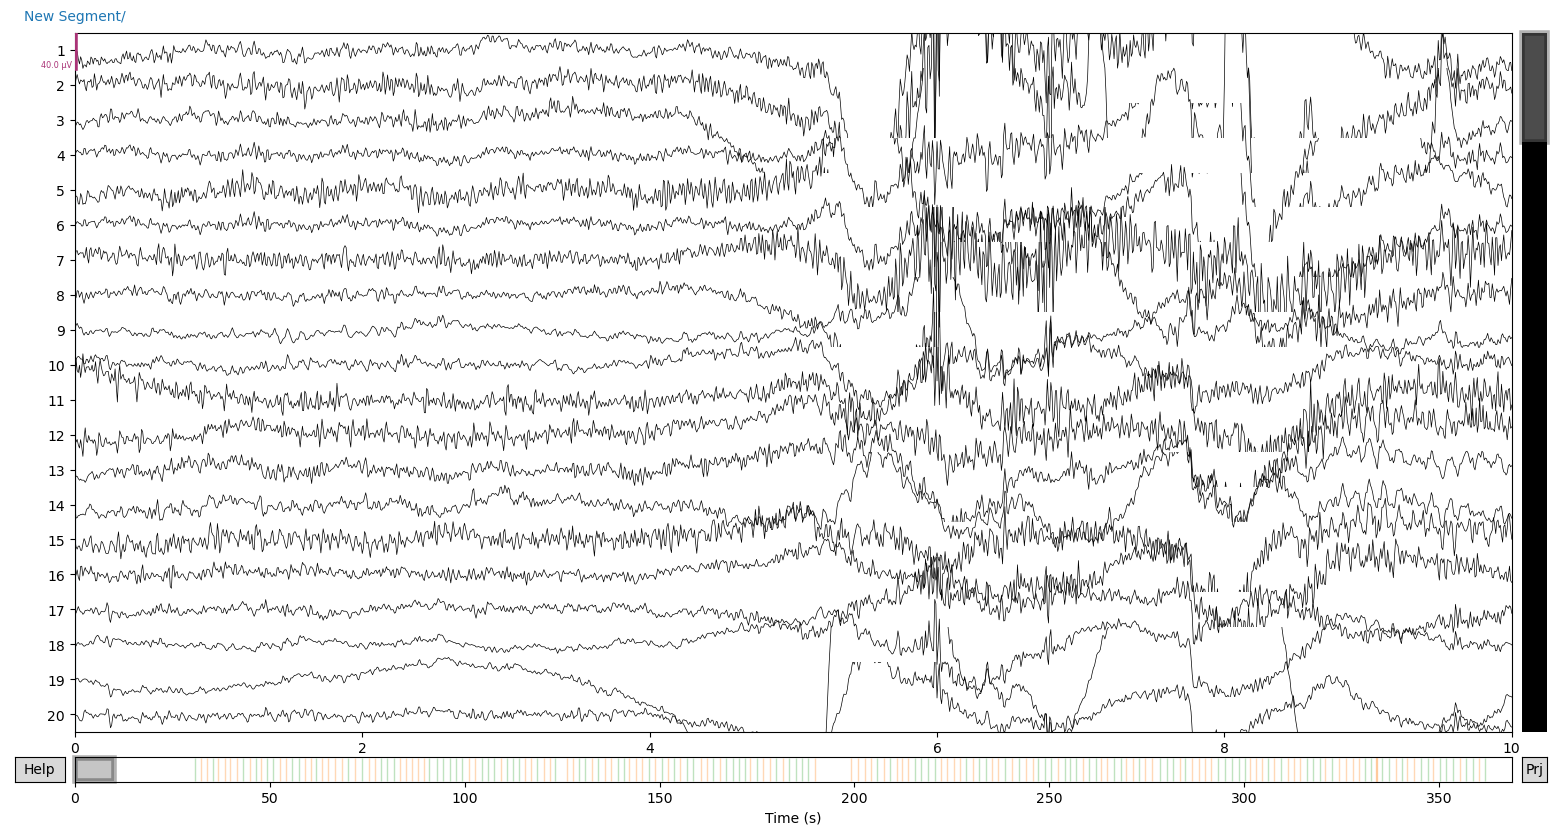

In [7]:
#to change the plot if channels still need to be removed
raw2.plot()

In [8]:
#AUTOREJ ROUTE:
epochs_ar = autorej(epochs)

Running autoreject on ch_type=eeg


c:\Users\aar40\Anaconda3\envs\mne\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 67%|██████▋   | Creating augmented epochs : 83/124 [00:24<00:11,    3.46it/s]

: 

: 

In [ ]:
ica = ICA_auto_rej(epochs_ar)


Fitting ICA to data using 72 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)


C:\Users\aar40\AppData\Local\Temp\ipykernel_10324\920166555.py:511: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_ar)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by non-zero PCA components: 71 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 81.0s.


    Applying projection operator with 1 vector (pre-whitener application)
Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=75, n_times=921600
    Range : 0 ... 921599 =      0.000 ...   368.640 secs
Ready.


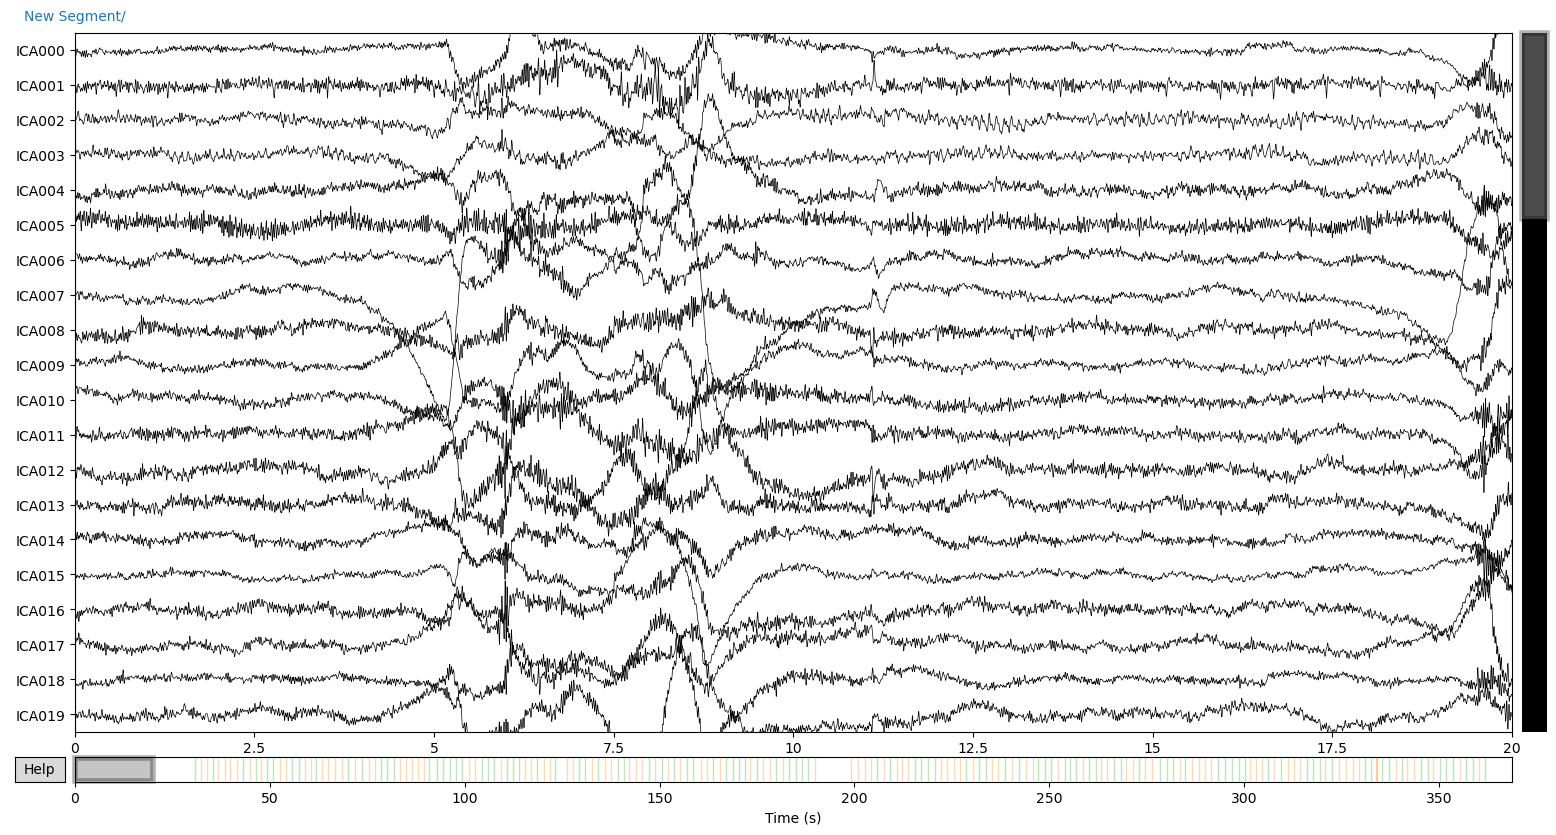

In [ ]:
ica.plot_sources(epochs_ar, show_scrollbars=True)     # to plot ICA vs time
ica.plot_sources(raw2, show_scrollbars=True)     # to plot ICA vs time


In [ ]:
reconst_evoked, reconst_raw = EOG_check_ar(epochs_ar, ica)


Using EOG channels: 125, 126, 127, 128
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)


C:\Users\aar40\AppData\Local\Temp\ipykernel_10324\920166555.py:328: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(inst=reconst_raw)


    Transforming to ICA space (71 components)
    Zeroing out 2 ICA components
    Projecting back using 72 PCA components


In [ ]:
ica.exclude = [0,1,0,1] # MANUAL INPUT


In [ ]:
raw2.save(pathlib.Path(D_drive + os.sep + subj + os.sep + 'Digitization') / 'Captrak_Digitization.fif', overwrite = True)

Writing D:\mnt\d\Aidan\E4\Digitization\Captrak_Digitization.fif


C:\Users\aar40\AppData\Local\Temp\ipykernel_10324\4147856500.py:1: RuntimeWarning: This filename (D:\mnt\d\Aidan\E4\Digitization\Captrak_Digitization.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw2.save(pathlib.Path('/mnt/d/Aidan/' + subj + '/Digitization') / 'Captrak_Digitization.fif', overwrite = True)


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\mnt\\d\\Aidan\\E4\\Digitization\\Captrak_Digitization.fif'

In [ ]:
noise_cov, fig_cov, fig_spectra, evoked = covariance(reconst_raw)

Computing rank from data with rank=None
    Using tolerance 1.1e-10 (2.2e-16 eps * 72 dim * 7e+03  max singular value)
    Estimated rank (eeg): 70
    EEG: rank 70 computed from 72 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 72 -> 70
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 201411
log-likelihood on unseen data (descending order):
   shrunk: -159.705
   empirical: -159.707
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 3.9e-14 (2.2e-16 eps * 72 dim * 2.4  max singular value)
    Estimated rank (eeg): 70
    EEG: rank 70 computed from 72 data channels with 1 projector
2 projection items activated
    EEG regularization : 0.1
    Created an SSP operator (subspace dimension = 1)
Computing rank

In [ ]:
data_path = D_Drive + os.sep + subj + os.sep + 'Digitization'
data = pathlib.Path(data_path) / 'Captrak_Digitization.fif'

In [ ]:
trans = pathlib.Path(data_path)/ (subj + '-trans.fif')

In [ ]:
model = mne.make_bem_model(subject=subj, subjects_dir=SUBJECTS_DIR)

Creating the BEM geometry...


ValueError: not enough values to unpack (expected 3, got 0)

In [ ]:
#if bem isn't generated run this
mne.bem.make_watershed_bem(subject=subj, subjects_dir=SUBJECTS_DIR, overwrite=True, volume='T1')

In [ ]:
bem_sol = mne.read_bem_solution(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + subj+ '_bem.fif')

FileNotFoundError: fname does not exist: D:\Aidan\E4\Digitization\E4_bem.fif

In [ ]:
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem_sol, meg=False, eeg=True, n_jobs=1) # mindist=5.0,

In [ ]:
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov)

In [ ]:
stc = mne.minimum_norm.apply_inverse(reconst_evoked, inv, method = 'eLORETA', lambda2 = 0.1111111111111111111111111111111)

In [ ]:
stc.plot(hemi = 'split',smoothing_steps = 5, surface = 'pial')  # hemi = 'both'